# Hype in the Video-game Industry.

### Analyzing the Effect of Spatial Proximity and Consumer Opinion Dynamics on Game Sales.




In [1]:
#Import packages
import pandas as pd
import random as rd
import networkx as net
import numpy as np
from numpy import *
import pylab
import sklearn
from sklearn import *
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
%matplotlib inline

#Fix random seed
np.random.seed(111111)

#Useful functions:
	#Draw simulated space based on consumer agent coordinates. 
def draw_space(elements,stores):
	figure = plt.Figure(figsize=(16,9))
	ax = figure.add_subplot(111)
	
	x_ = [float(i.position_xy[0]) for i in elements if i.opinion < 0]
	y_ = [float(i.position_xy[1]) for i in elements if i.opinion < 0]
	print 'Negatives: '+str(len(x_))
	plt.scatter(x_,y_,alpha=0.8,c='r')
	x_ = [float(i.position_xy[0]) for i in elements if i.opinion > 0]
	y_ = [float(i.position_xy[1]) for i in elements if i.opinion > 0]
	print 'Positives: '+str(len(x_))
	plt.scatter(x_,y_,alpha=0.8,c='b')

	x_ = [float(i.position_xy[0]) for i in stores]
	y_ = [float(i.position_xy[1]) for i in stores]
	plt.scatter(x_,y_,c='y',marker='s',s=20)
	plt.title('Spatial distribution of agents and stores.')
	#plt.axis('off')
	plt.show()

	#Draw simulated space based on clusters.
def draw_heat_space(elements,stores):
	figure = plt.Figure(figsize=(16,9))
	ax = figure.add_subplot(111)
	
	x = [float(i.position_xy[0]) for i in elements]
	y = [float(i.position_xy[1]) for i in elements]
	x_ = [float(i.position_xy[0]) for i in stores]
	y_ = [float(i.position_xy[1]) for i in stores]
	
	heatmap, xedges, yedges = np.histogram2d(x, y, bins=15)
	print heatmap[0]
	extent = [-1000, 1000, -1000, 1000]
	
	plt.imshow(heatmap, interpolation='nearest', extent=extent)#extent=extent)
	plt.axis('off')

	plt.scatter(x_,y_,c='y',marker='s',s=20)
	plt.title('Spatial distribution of agents and stores.')
	plt.axis('off')
	plt.show()
	

#Agents classes:
class agent():
	def __init__(self,ID,coeff,week):
		self.ID = int(ID)
		self.game_preference = rd.random()
		self.coeff = int(coeff)
		if self.coeff > population: self.coeff == population

		self.network, self.real_net = [], []
		self.activity = rd.paretovariate(1.8)
		self.socialize = week
		self.opinion = np.random.normal(0,0.1)
		self.type, self.consumer = 'user', False
		self.position_xy = 0
		self.my_store = 0

	def position(self,other):
		if other != 0:
			self.position_xy = [other[0]+rd.gauss(0,15),other[1]+rd.gauss(0,15)]
		else:
			self.position_xy = [rd.gauss(0,300),rd.gauss(0,300)]
			
	def communicate(self):
		if rd.paretovariate(1.8) >= self.activity:          
			sim.tweets[-1] += 1
			if self.opinion > 0:
				sim.pos[-1] += 1
			elif self.opinion < 0:
				sim.neg[-1] += 1
			for a in self.network:
				if rd.paretovariate(1.8) >= sim.agents[a].activity:
					if self.type == 'hub':
						sim.agents[a].opinion += float(self.opinion)*.015
					elif self.type == 'user':
						sim.agents[a].opinion += float(self.opinion)*.03
						
		if rd.randint(0,28) < 28 and self.socialize < sim.week and local == True:
			self.socialize += 1
			if len(self.real_net) < 5:
				friends = self.real_net
			else:
				friends = [self.real_net[i] for i in sorted(rd.sample(xrange(len(self.real_net)), 4)) ]
			for a in friends:
				sim.agents[a].opinion += float(self.opinion)*.3
            

	def buy(self):
		#If opinion/expectative of the game is greater than game 'good-enough' parameter then buy it.
		if self.opinion > self.game_preference and self.consumer == False:
			sim.game_sell += 1
			#Difference between game quality and preference (or 'good-enough' threshold) adds up to current opinion.
			d = sim.game - self.game_preference
			self.opinion += float(d/2)
			self.consumer = True
	
	def adjust(self):
		if self.opinion > 1:
			self.opinion = 1
		elif self.opinion < -1:
			self.opinion = -1
            
class store():
	def __init__(self,ID,coeff):
		self.ID = int(ID)
		self.coeff = int(coeff)
		self.position_xy = 0
		self.clients = []

class world():
	def __init__(self):
		self.week, self.temp = 0, 0
		self.agents = [agent(i,rd.paretovariate(1.8)*2,self.week) for i in range(population)]
		self.stores = [store(i,rd.paretovariate(1.8)*2) for i in range(n_stores)]
		self.game, self.game_weeks, self.game_sell = rd.random(), {str(i):0 for i in range(16)}, 0
		self.tweets = [0]
		self.neg = [0]
		self.pos = [0]
        
		self.initialize_space_and_networks()

		opinions = [i.opinion for i in self.agents]
		op_h = np.histogram(opinions,bins=10)
		plt.bar(op_h[1][:-1],op_h[0],width=float(max(opinions)-min(opinions))/10)
		plt.title('Initial opinions.')
		plt.show()
		
	def step(self):
		self.temp += 1
		if self.temp == 28:
			self.temp = 0
			self.week += 1
			self.game_weeks[str(self.week)] += self.game_sell
			self.game_sell = 0
			
		for a in self.agents:
			a.adjust()
			a.communicate()
			if self.week > 4: #Game is now available.
				a.buy()
		
		self.tweets.append(0)
		self.pos.append(0)
		self.neg.append(0)

	def initialize_space_and_networks(self):
		agent_ids, net_distro = [int(i.ID) for i in self.agents], []
		
		for a in self.agents:
			if a.coeff > population: a.coeff = population
			a.position(self.agents[rd.randint(0,population-1)].position_xy)
			a.network = rd.sample(xrange(len(agent_ids)), a.coeff)
			net_distro.append(len(a.network))
		x_ = [float(i.position_xy[0]) for i in self.agents]
		y_ = [float(i.position_xy[1]) for i in self.agents]
		x_l = [[x_[i],y_[i]] for i in range(len(x_))]
		X = array(x_l)

		#Get centroids of population clusters.
		ms = MeanShift(bandwidth=95, bin_seeding=True,cluster_all=False)
		ms.fit(X)
		cluster_centers = ms.cluster_centers_
		xy_c = cluster_centers

		for s in self.stores:
			try:
				s.position_xy = [xy_c[s.ID][0],xy_c[s.ID][1]]
			except:
				pass

		for a in self.agents:
			if len(a.network) > net_distro[int(len(net_distro)*0.95)]: 
				a.type = 'hub'
			dist = []
			for s in self.stores:
				dist.append(sqrt((a.position_xy[0]-s.position_xy[0])**2+(a.position_xy[1]-s.position_xy[1])**2))
			a.my_store = dist.index(min(dist))
			self.stores[a.my_store].clients.append(a.ID)

		for a in self.agents:
			a.real_net = self.stores[a.my_store].clients           
			a.real_net.remove(a.ID)

		#Plot initial space distribution of opinions
		draw_space(self.agents,self.stores)

C:\Users\Andre\Anaconda22\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Users\Andre\Anaconda22\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


Negatives: 525
Positives: 475


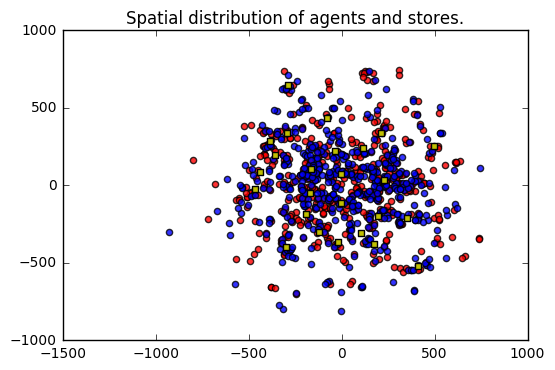

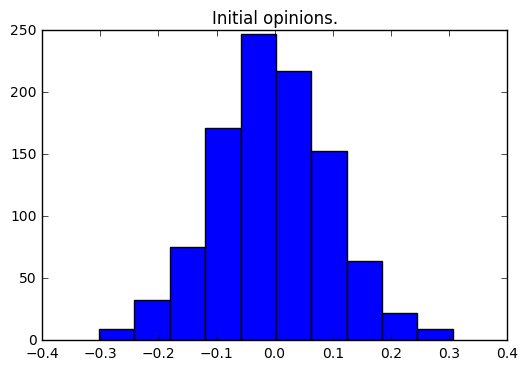

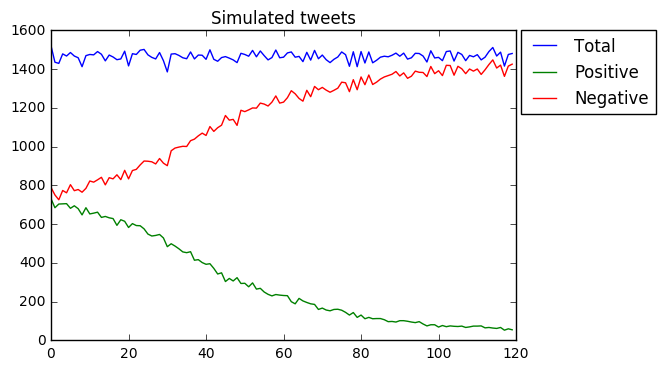

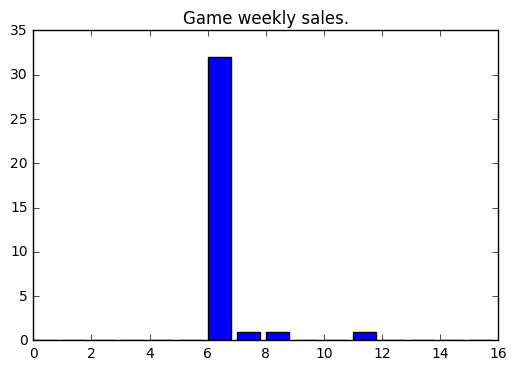

Negatives: 949
Positives: 51


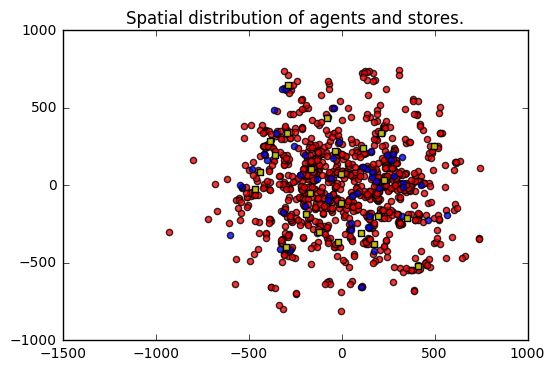

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


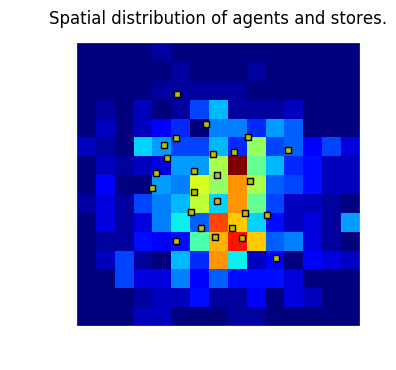

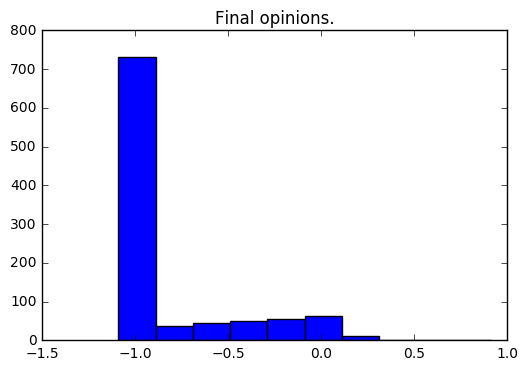

In [2]:
#Initial parameters.
population = 1000
n_stores = 25
days = 120 #November 8 to March 9 
local = True

#Run simulation.
sim = world()
for i in range(days*3):
    sim.step()
draw_network = False

def get_ts(tweets,color,lab):
    twits,day,total = [],0,0
    for i in tweets:
        total += i
        day += 1
        if day == 3:
            twits.append(total)
            total,day = 0,0
    plt.plot(twits,c=color,label=lab)

#Plot simulated tweets.
get_ts(sim.tweets,'b','Total')
get_ts(sim.pos,'g','Positive')
get_ts(sim.neg,'r','Negative')
plt.title('Simulated tweets')
plt.legend(bbox_to_anchor=(1.3, 1),borderaxespad=0.)
plt.show()

#Plot bar graph of game sales.
y =[sim.game_weeks[str(i)] for i in range(16)]
plt.bar(np.arange(len(y)),y)
plt.title('Game weekly sales.')
plt.show()

#Plot final opinions in space.
draw_space(sim.agents,sim.stores)

#Plot population density and stores references.
draw_heat_space(sim.agents,sim.stores)

#Plot final opinion distribution.
opinions = [i.opinion for i in sim.agents]
op_h = np.histogram(opinions,bins=10)
plt.bar(op_h[1][:-1],op_h[0],width=0.2)
plt.title('Final opinions.')
plt.show()